In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

In [242]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # для прогресс-бара
import matplotlib.pyplot as plt
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import accuracy_score
from numpy.linalg import norm
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors  # <-- импортируем класс
from sklearn.utils.extmath import randomized_svd
from sklearn.utils.extmath import randomized_svd


In [310]:
dataset_path = r'C:\Users\dgfjo\OneDrive\Desktop\Новая папка\lfw-deepfunneled\lfw-deepfunneled'
N_COMPONENTS=50
THETA=0.18

### Загрузка и обработка изображений из датасета LFW

В этом блоке реализованы две функции:
- `load_image` — загружает и обрабатывает отдельное изображение (меняет размер до 250x250 пикселей);
- `load_lfw_dataset` — рекурсивно обходит папки с фотографиями людей, параллельно загружает изображения и возвращает массив изображений и соответствующие метки.

In [3]:

def load_image(file_path):
    """Загрузка и обработка одного изображения"""
    try:
        img = Image.open(file_path)
        # Изменение размера до 250x250 с сохранением цветовых каналов
        img = img.resize((250, 250))
        return np.array(img)
    except Exception as e:
        print(f"Ошибка загрузки {file_path}: {e}")
        return None

def load_lfw_dataset(dataset_path, max_workers=4):
    """
    Загрузка только изображений с параметрами:
    - dataset_path: путь к корневой папке с подпапками персон
    - max_workers: количество потоков для параллельной обработки
    """
    # Проверка существования основной папки
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Папка {dataset_path} не найдена!")

    images = []
    labels = []
    
    # Создаем список всех изображений
    file_list = []
    for person_folder in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person_folder)
        if os.path.isdir(person_path):
            for img_file in os.listdir(person_path):
                img_path = os.path.join(person_path, img_file)
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_list.append((img_path, person_folder))

    # Параллельная загрузка с прогресс-баром
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for img_path, label in file_list:
            futures.append(executor.submit(load_image, img_path))
        
        # Обработка результатов
        for i, future in enumerate(futures):
            img_array = future.result()
            if img_array is not None:
                images.append(img_array)
                labels.append(file_list[i][1])
            # Вывод прогресса
            if (i+1) % 100 == 0 or (i+1) == len(futures):
                print(f"Обработано {i+1}/{len(futures)} изображений", end='\r')

    # Преобразование в numpy массивы
    images_array = np.array(images)
    labels_array = np.array(labels)
    
    print(f"\nУспешно загружено {len(images_array)} изображений")
    print(f"Размерность данных: {images_array.shape}")
    
    return images_array, labels_array

# Пример использования

   

In [4]:
dataset_path = r'C:\Users\dgfjo\OneDrive\Desktop\Новая папка\lfw-deepfunneled\lfw-deepfunneled'
    
try:
    X, y = load_lfw_dataset(dataset_path, max_workers=8)
        
        # Пример вывода информации
    print("\nПример метки:", y[0])
    print("Форма изображения:", X[0].shape)
    print("Диапазон значений пикселей:", X[0].min(), "-", X[0].max())
        
except Exception as e:
    print(f"\nОшибка: {str(e)}")
    print("Проверьте:")
    print("- Путь к данным")
    print("- Наличие изображений в подпапках")
    print("- Права доступа к файлам")

Обработано 13233/13233 изображений
Успешно загружено 13233 изображений
Размерность данных: (13233, 250, 250, 3)

Пример метки: Aaron_Eckhart
Форма изображения: (250, 250, 3)
Диапазон значений пикселей: 0 - 239


### Визуализация случайных изображений из набора данных

Выведем 6 случайных изображений с их метками.

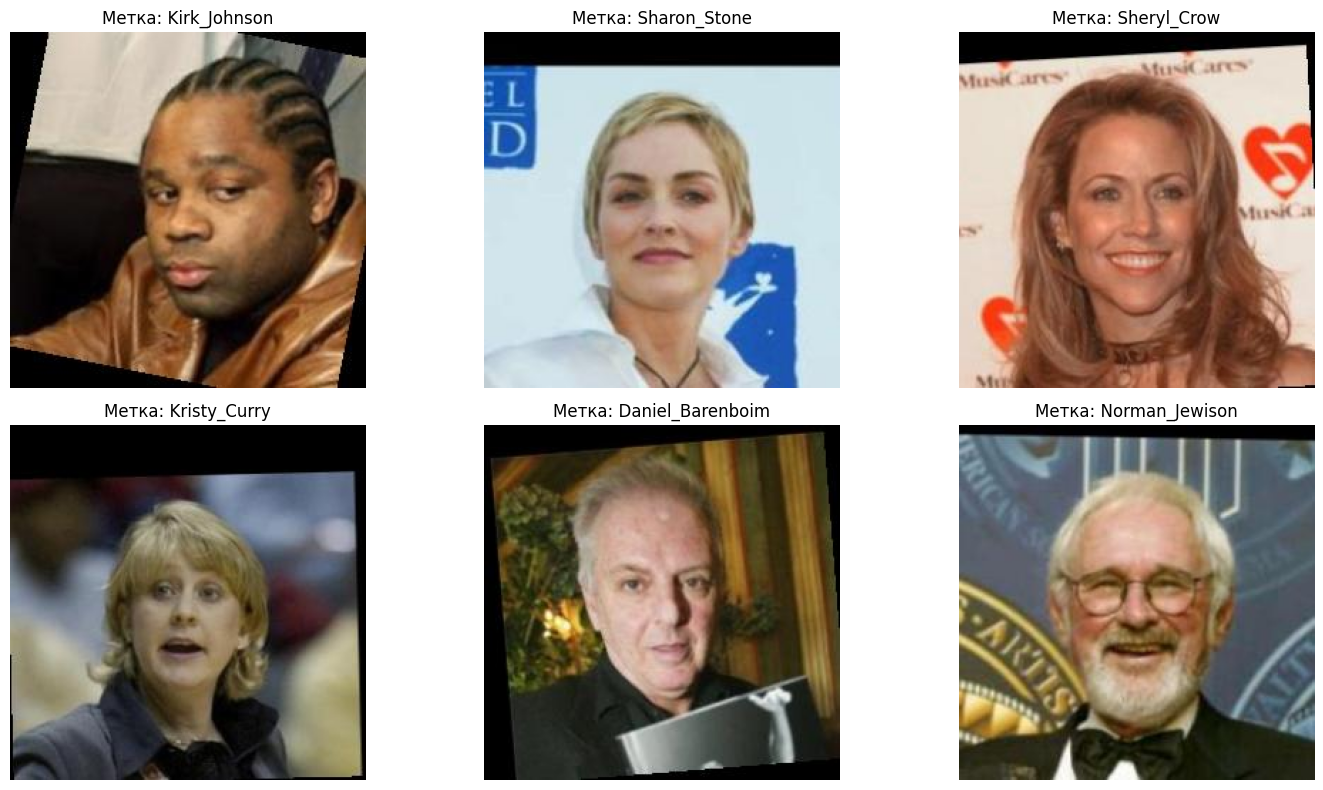

In [5]:
if len(X) > 0:
    # Вывод 6 случайных изображений с метками
    plt.figure(figsize=(15, 8))
    for i in range(6):
        idx = np.random.randint(len(X))
        plt.subplot(2, 3, i+1)
        
        # Для grayscale (если изображения черно-белые)
        if X[idx].shape[-1] == 1 or len(X[idx].shape) == 2:
            plt.imshow(X[idx], cmap='gray')
        else:
            plt.imshow(X[idx])
            
        plt.title(f"Метка: {y[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Нет изображений для отображения")

### Конвертация изображений в оттенки серого и визуализация

Функция `convert_to_grayscale` преобразует цветные изображения (формат N×H×W×3) в оттенки серого (N×H×W),  
используя классическую формулу взвешенного суммирования каналов.  

Функция `show_random_gray_images` выводит случайные изображения в оттенках серого с подписями меток.

In [6]:
def convert_to_grayscale(X):
    # X - массив (N, H, W, 3), возвращает (N, H, W)
    return np.dot(X[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)

In [7]:
#приводим к оттенкам серого (уменьшаем размерность)
X_gray = convert_to_grayscale(X)

In [9]:
def show_random_gray_images(X_gray, y, n=8):
    indices = np.random.choice(len(X_gray), size=n, replace=False)
    rows = 2
    cols = (n + 1) // 2  # округляем вверх, если n нечетное
    
    plt.figure(figsize=(cols * 3, rows * 4))  # размер подстраиваем под количество
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X_gray[idx], cmap='gray')
        plt.title(y[idx], fontsize=10)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

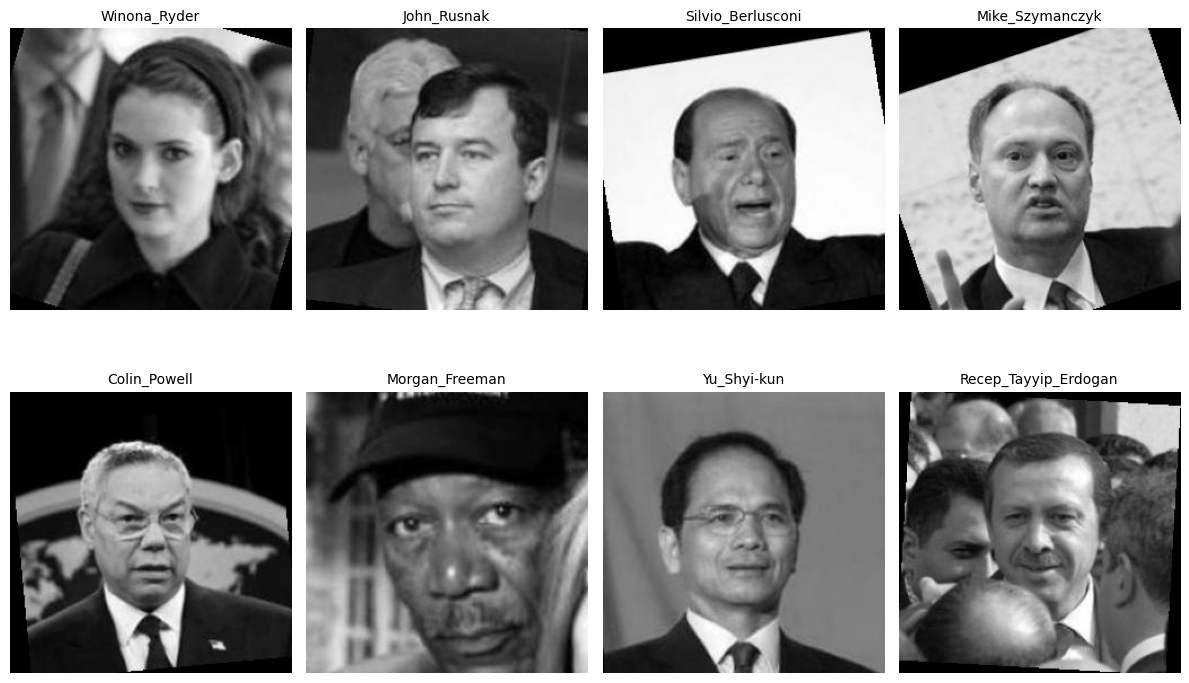

In [10]:
show_random_gray_images(X_gray, y, n=8)

### Предобработка данных и разбиение на обучающую и тестовую выборки

Выполняется:

- Приведение изображений к типу float32 и нормализация пикселей в диапазон [0, 1].
- Преобразование изображений в векторы (для подачи в классификатор).
- Разбиение данных на обучающую и тестовую выборки с фиксированным random_state для воспроизводимости.


In [11]:
def preprocess_data(X):
    """
    Предобработка массива изображений:
    - Приведение к float32
    - Нормализация пикселей в диапазон [0, 1]
    Возвращает предобработанный массив того же размера.
    """
    X = X.astype('float32') / 255.0  # нормализация к [0,1]
    return X

In [57]:
X_processed = preprocess_data(X_gray)

In [58]:
X_X_processed_NN = X_processed.reshape(len(X_processed), -1)  # (N, 100*100)

In [59]:
def split_dataset(X, y, test_size=0.3, random_state=42):
    return train_test_split(X_X_processed_NN, y, test_size=test_size, random_state=random_state)

In [60]:
X_train, X_test, y_train, y_test = split_dataset(X_X_processed_NN, y)
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 9263
Размер тестовой выборки: 3970


# Класс FaceRecognizer

**Описание:**  
Распознавание лиц с использованием SVD и KNN с различными метриками расстояния.

---

## Основные шаги

1. **Центрирование данных:**  
   $$ X_{\text{centered}} = X - \bar{X} $$  
   где $\bar{X}$ — среднее значение по признакам.

2. **SVD-разложение:**  
   $$ X_{\text{centered}} \approx U \Sigma V^T $$  
   Берутся первые *n_components* строк матрицы $V^T$ (главные компоненты).

3. **Проекция на пространство главных компонент:**  
   $$ X_{\text{proj}} = X_{\text{centered}} V^T $$

4. **Нормализация (только для косинусной метрики):**  
   $$ X_{\text{norm}} = \frac{X_{\text{proj}}}{\|X_{\text{proj}}\|_2} $$

5. **Обучение KNN** с выбранной метрикой (`cosine`, `euclidean`, `manhattan`).

- Порог `theta` регулирует, насколько близко должен быть сосед для распознавания.  

In [307]:

class FaceRecognizer:
    def __init__(self, n_components=100, metric='cosine'):  
        """
        n_components: число главных компонент для SVD
        metric: метрика расстояния для KNN ('cosine', 'euclidean', 'manhattan')
        """
        self.n_components = n_components
        self.metric = metric
        self.mean = None
        self.proj = None
        self.knn = KNeighborsClassifier(n_neighbors=3, metric=self.metric)
        self.y_train = None

    def fit(self, X, y):
        """Обучение модели с L2-нормализацией"""
        self.mean = X.mean(axis=0)
        X_centered = X - self.mean
        
        # SVD для выделения главных компонент
        _, _, Vt = randomized_svd(
            X_centered,
            n_components=self.n_components,
            n_iter=5,
            random_state=42
        )
        self.proj = Vt
        
        # Проекция и нормализация (нормализация особенно важна для косинуса)
        X_proj = X_centered @ self.proj.T
        
        # Для косинусной метрики — делаем L2-нормализацию
        if self.metric == 'cosine':
            X_proj /= np.linalg.norm(X_proj, axis=1, keepdims=True)
        
        self.y_train = y
        self.knn.fit(X_proj, y)

    def predict(self, X, i=0, theta=0.3):
        """
        Предсказание классов с порогом theta.
        Вывод расстояний, если i=1.
        """
        X_centered = X - self.mean
        X_proj = X_centered @ self.proj.T

        if self.metric == 'cosine':
            X_proj /= np.linalg.norm(X_proj, axis=1, keepdims=True)

        dists, idx = self.knn.kneighbors(X_proj)

        if i == 1:
            print("Минимальное расстояние до соседа:", dists[:,0].min(),
              "Максимальное:", dists[:,0].max())

        # Возвращаем либо метку, либо "unknown"
        return np.where(dists[:,0] < theta, self.y_train[idx[:,0]], "unknown")


In [311]:
# Обучение модели

print("\nОбучение модели...")
model = FaceRecognizer(n_components=N_COMPONENTS)
model.fit(X_train, y_train)
print("\nмодель обучена")


Обучение модели...

модель обучена


## Визуализация восстановления изображений с помощью SVD-проекций

В этой части мы визуализируем, как изображения лиц можно восстановить после проекции в подпространство, построенное с помощью SVD. Это позволяет понять, насколько хорошо модель захватывает информацию об изображении при ограниченном числе компонент.

---

###  Идея восстановления

После центрирования и проецирования изображения на подпространство, восстановление выполняется следующим образом:

- Центровка изображения:
  
  $X_{\text{centered}} = X - \mu$
  

  где $ \mu $ — вектор средних значений по каждому пикселю.

- Проекция в подпространство из $ k $ главных компонент:

  $
  Z = X_{\text{centered}} \cdot V_k^T
  $

- Восстановление изображения:

  $\
  \hat{X} = Z \cdot V_k + \mu
  $

  где $ V_k \in \mathbb{R}^{k \times d}  $— матрица из первых $ k  $сингулярных векторов.

---

###  Итог

- Чем выше значение $ k $, тем более точно восстанавливается изображение.
- При малых $ k $ картинка может терять детали, но основные черты лица сохраняются.
- Это демонстрирует, что даже сжатое представление может быть информативным для задачи распознавания.

---


In [291]:
def show_reconstruction(model, X, indices, image_shape=(250, 250)):
    """
    Визуализация исходных и восстановленных изображений
    model — обученная модель FaceRecognizer
    X — исходные изображения (в виде векторов)
    indices — индексы изображений, которые хотим показать
    image_shape — форма изображения (по умолчанию 250x250)
    """
    X_centered = X - model.mean
    X_proj = X_centered @ model.proj.T
    X_reconstructed = X_proj @ model.proj + model.mean

    n = len(indices)
    plt.figure(figsize=(8, 4 * n))
    for i, idx in enumerate(indices):
        # Исходное
        plt.subplot(n, 2, 2*i+1)
        plt.imshow(X[idx].reshape(image_shape), cmap='gray')
        plt.title("Оригинал")
        plt.axis('off')
        
        # Восстановленное
        plt.subplot(n, 2, 2*i+2)
        plt.imshow(X_reconstructed[idx].reshape(image_shape), cmap='gray')
        plt.title("Восстановлено из проекции")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

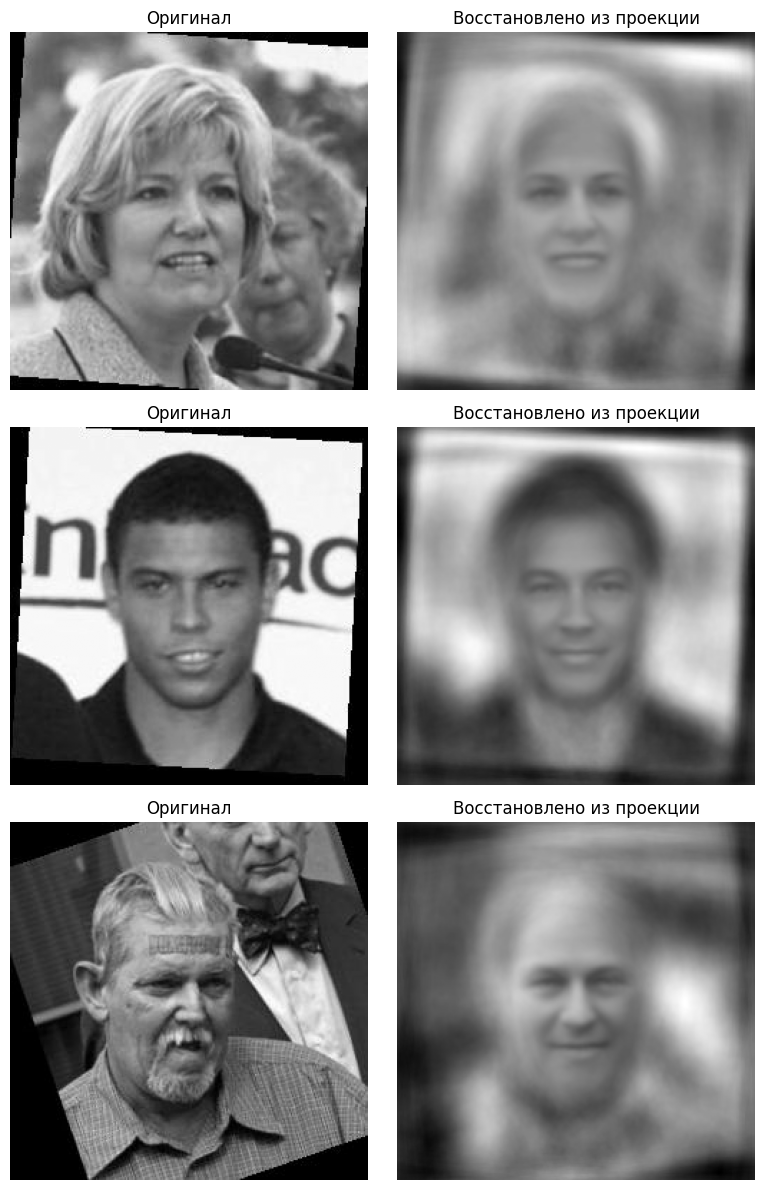

In [292]:
# Покажем, например, первые 3 изображения из обучающей выборки
show_reconstruction(model, X_train, indices=[0, 1, 2])

In [301]:
#функция оценки точности
def evaluate_full_accuracy(y_true, y_pred, known_classes):
    """
    Оценивает точность, учитывая:
    - корректную классификацию известных людей,
    - корректное предсказание "unknown" для новых лиц.
    """
    correct = 0
    total = len(y_true)
    
    for yt, yp in zip(y_true, y_pred):
        if yt in known_classes:
            if yt == yp:
                correct += 1
        else:
            if yp == "unknown":
                correct += 1
    
    return correct / total

In [294]:
# Проекция 
y_pred = model.predict(X_test,1, THETA)


Минимальное расстояние до соседа: 0.001085043 Максимальное: 0.60665107


In [295]:
print("\nТестирование...")
known_classes = np.unique(model.y_train)
accuracy = evaluate_full_accuracy(y_test, y_pred, known_classes)
print(f"Точность модели (с учётом новых лиц): {accuracy:.2%}")


Тестирование...
Точность модели (с учётом новых лиц): 28.77%


In [296]:

best_theta = None
best_accuracy = 0
accuracies = []
thetas = np.linspace(0.1, 0.9, 50)  # Диапазон theta (можно подправить по результатам min/max dists)

known_classes = np.unique(model.y_train)

for theta in thetas:
    y_pred = model.predict(X_test,0, theta=theta)
    acc = evaluate_full_accuracy(y_test, y_pred, known_classes)
    accuracies.append(acc)
    
    # print(f"Theta: {theta:.3f} | Accuracy: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_theta = theta

print("\nЛучшее значение theta:", best_theta)
print("Максимальная точность:", f"{best_accuracy:.2%}")


Лучшее значение theta: 0.1
Максимальная точность: 33.58%


# Число вектекторов разложения 100


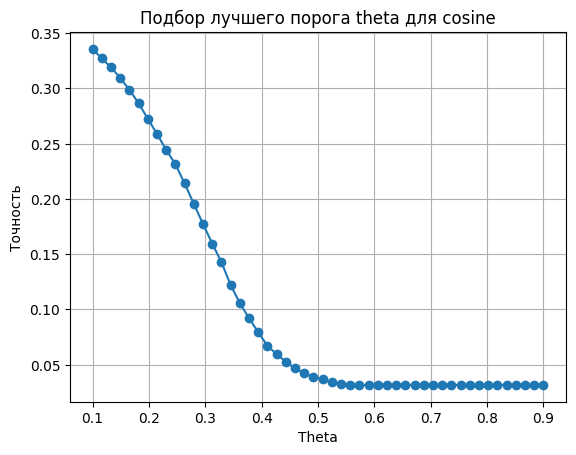

In [297]:


plt.plot(thetas, accuracies, marker='o')
plt.xlabel("Theta")
plt.ylabel("Точность")
plt.title("Подбор лучшего порога theta для cosine")
plt.grid(True)
plt.show()

# Число вектекторов разложения 50


In [ ]:
best_theta = None
best_accuracy = 0
accuracies = []
thetas = np.linspace(0.05, 0.9, 50)  # Диапазон theta (можно подправить по результатам min/max dists)

known_classes = np.unique(model.y_train)

for theta in thetas:
    y_pred = model.predict(X_test,0, theta=theta)
    acc = evaluate_full_accuracy(y_test, y_pred, known_classes)
    accuracies.append(acc)
    
   
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_theta = theta

print("\nЛучшее значение theta:", best_theta)
print("Максимальная точность:", f"{best_accuracy:.2%}")
plt.plot(thetas, accuracies, marker='o')
plt.xlabel("Theta")
plt.ylabel("Точность")
plt.title("Подбор лучшего порога theta для cosine. к=50")
plt.grid(True)
plt.show()